In [ ]:
!pip install -q geopandas
!apt install -q proj-bin libproj-dev libgeos-dev -y
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q rasterio

# Pandas is a package containing additional functions to use data frames in Python
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import warnings
import rasterio
import numpy as np
import seaborn as sns
warnings.simplefilter('ignore')
# These two lines allow the notebook to access the Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# This is the path to the project folder within the Google Drive.
file_path = "/content/drive/My Drive/"
import rpy2.interactive

%load_ext rpy2.ipython

from rpy2.robjects import pandas2ri  # activate pandas R  interface
pandas2ri.activate()

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Mounted at /content/drive
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Here we load some packages in another programming language - R. We won't use this language very much (because I prefer Python), but we will briefly switch languages to run the model because the tool to run it requires this language.

Running this cell might take a a couple of minutes.

In [ ]:
 %%R
install.packages('rgeos', quiet=TRUE)
install.packages('raster', quiet=TRUE)
install.packages('rgdal', quiet=TRUE)
install.packages('maptools', quiet=TRUE)
install.packages('dismo', quiet=TRUE)

require('rgdal', quiet=TRUE)
require('rgeos', quiet=TRUE)
require('maptools', quiet=TRUE)
require('dismo', quiet=TRUE)
require('raster', quiet=TRUE)


In [ ]:
%%R
install.packages('randomForest', quiet=TRUE)
require('randomForest', quiet=TRUE)


In [ ]:
def convert_xy_to_longlat(grid_x, grid_y):
  lon = ((grid_x / 6) - 180)
  lat = -((grid_y / 6) - 90)
  return (lon, lat)

def convert_longlat_to_xy(lon, lat):
  grid_x = int((lon + 180) * 6)
  grid_y = int((-lat + 90) * 6)
  return (grid_x, grid_y)

---

## Notebook 14
# Applying Species Distribution Models

We can finally start running species distribution models on the data and predicting how species distributions may change under various climate change models and scenarios.

We can start by running everything for just one species - Lasius niger.

First we choose the species we want to run.  For now we'll run this on the worldwide data, rather than a specific continent.

For this notebook I've just picked one model and two ssps, but all four time periods.

In [ ]:
species_name = 'Apis_mellifera'
continent = 'World'


models = ['MIROC6']
scenarios = ['ssp126', 'ssp585']

time_periods = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']


This cell sets up parts of the grid to focus the analysis on if we later want to look at specific continents - for now it just takes all of the locations.

In [ ]:
# Create an empty dictionary
boundaries = dict()

# Fill in the boundaries of each continent
boundaries['Europe'] = [((1000, 1200)), ((325, 100))]
boundaries['North America'] = [((100, 800)), ((600, 0))]
boundaries['South America'] = [((500, 950)), ((900, 400))]
boundaries['Australia'] = [((1700, 2000)), ((850, 550))]
boundaries['Africa'] = [((950, 1500)), (830, 250)]
boundaries['Asia'] = [((1200, 2160)), (600, 0)]
boundaries['World'] = [((0, 2160)), ((930, 0))]

# Select the continent of interest
this_boundary = boundaries[continent]

Next we can read the species observations for the near-present timepoint for the presence and absence data into R.

In [ ]:
# read the presence data
presence_table = pd.read_csv(file_path + "species_plus_climate_observed_geo/" + species_name + ".tsv", sep="\t")
# add a column to show these points are where the species is present
presence_table['p'] = 1
# filter to keep only data in one continent
if continent != 'World':
  if continent == 'Eurasia':
    presence_table = presence_table[presence_table['Continent'].isin(['Europe', 'Asia'])]
  else:
    presence_table = presence_table[presence_table['Continent'] == continent]
# read the absence data
absence_table = pd.read_csv(file_path + "species_plus_climate_observed_absence/" + species_name + "_geo.tsv", sep="\t")
absence_table['p'] = 0
if continent != 'World':
  if continent == 'Eurasia':
    absence_table = absence_table[absence_table['Continent'].isin(['Europe', 'Asia'])]
  else:
    absence_table = absence_table[absence_table['Continent'] == continent]


For each point in the map, the SDM will predict whether, given a the set of enviornmental data, the species will be present or absent.

In order to test that our SDMs are working, we need some points at which we already know if the species is present or absent.

To do this, we take a sample out of the table presence / absence data for each species - in this case we'll take 5% of the data.  We call this the "test" data.  We then build the model based on the remaining 95% of the data - the "training" data.

Here we select the random samples and extract them from the tables.


In [ ]:
# Calculate the sample size for the presence and absence data - 5% of the total number of records
sample_size_presence = int(len(presence_table) * 0.05)
sample_size_absence = int(len(absence_table) * 0.05)

# take a random 5% of observation IDs for the presence data
sample_presence = np.random.choice(presence_table['obs_ID'], sample_size_presence)

# take a random 5% of observation IDs for the absence data
sample_absence = np.random.choice(absence_table['obs_ID'], sample_size_absence)

# extract the 5% of samples for testing
training_presence = presence_table[~presence_table['obs_ID'].isin(sample_presence)]
training_absence = absence_table[~absence_table['obs_ID'].isin(sample_absence)]


# extract the 95% of samples for training
testing_presence = presence_table[presence_table['obs_ID'].isin(sample_presence)]
testing_absence = absence_table[absence_table['obs_ID'].isin(sample_absence)]

# combine the testing and training data for presence and absence
testing_combined = testing_presence.append(testing_absence)
training_combined = training_presence.append(training_absence)

# remove the extra columns (with non-climate data e.g. latitude and longitude)
# from the testing and training tables
testing_combined = testing_combined[list(bioclim_name.values()) + ['p']].astype(float)
training_combined = training_combined[list(bioclim_name.values()) + ['p']].astype(float)

Now we want to read our raster data, so that the model can predict presence or absence at different timepoints based on environmental variables.

First we read the "near-present" WORLDCLIM raster into Python and filter it as normal.

In [ ]:
# set the paths to the raster files for current and predicted climate
raster_path_current = file_path + "climate_data/" + "near_present.tif"

raster_current = rasterio.open(raster_path_current)
# convert the data into a matrix, round to 6dp, replace inf with nan
grid_current = raster_current.read()
grid_current = np.round(grid_current, 6)
grid_current[grid_current == float('-inf'), ] = float('nan')
# exclude very low latitudes
gc = grid_current[:, this_boundary[1][1]:this_boundary[1][0], this_boundary[0][0]:this_boundary[0][1]]

Each layer of the raster corresponds to a bioclim variable, so we read the bioclim variable names into Python as usual.

In [ ]:
# make a dictionary of bioclim variable names for convinence
bioclim = pd.read_csv(file_path + "bioclim.tsv", sep="\t")
bioclim_name = dict(zip(bioclim['variable_number'], bioclim['name']))

# make a list of bioclim variables 
bc = list(bioclim_name.values())

We want to read the raster data into R so that we can use it as an input for the SDM.

R can't read data directly from Google Drive inside Google Colab so we have to mess around with it a bit to pass the data from Python to R.


Lines which start with ```%R``` are R, rather than Python code.

Cells which start with ```%%R``` contain all R code.

```%R -i``` passes a variable from Python into R

In [ ]:
# pass the dataframes in to R
%R -i testing_combined
%R -i training_combined

# pass the list of Bioclim variables into R
%R -i bc

It's not possible to pass the stacked raster data into R, so I make a matrix for each layer of the raster in Python and pass them into R one by one.

This cell is again a mixture of R and Python

In [ ]:
 # make an empty R raster object
%R raster_current = raster()

# for each layer of the raster grid
for i in np.arange(0, 19, 1):
    # extract a single layer from the Python raster
    grid_current = gc[i]
    # pass the layer to R
    %R -i grid_current
    # convert to a matrix
    %R grid_matrix_current = as.matrix(grid_current)

    # find the minimum and maximum dimensions
    %R xmax_current = dim(grid_current)[1]
    %R ymax_current = dim(grid_current)[2]

    # convert to an R raster layer
    %R this_grid_current_raster = raster(grid_matrix_current, xmn=0, xmx=xmax_current, ymn=0, ymx=ymax_current, template=NULL)
    # add the layer to the big R raster
    %R raster_current = addLayer(raster_current, this_grid_current_raster)

# name the layers of the R raster using the Bioclim variable names
%R names(raster_current) = bc

[no name],['Annual_Mean_Temperature']
[no name],['Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp))']
[no name],['Isothermality_(BIO2/BIO7)_(×100)']
...,...
[no name],['Precipitation_of_Driest_Quarter']
[no name],['Precipitation_of_Warmest_Quarter']
[no name],['Precipitation_of_Coldest_Quarter']


We then do the same thing for all the combinations of models, ssps and time periods for the future predicted data.

This takes a while - up to 10 minutes - to run.

In [ ]:
# make an R list (equivalent to Python dictionary) to store the results
%R L = list()
%R j = 1
for model_future in models:
  for ssp_future in scenarios:
    for timepoint_future in time_periods:
      # Print a message so we know it's still running
      print ("Importing data for %s %s %s" % (model_future, ssp_future, timepoint_future))

      # generate the path to the raster data
      raster_path_future = file_path + "climate_data/" + model_future + "/" + ssp_future + "/" + timepoint_future + ".tiff"

      # read the raster into Python and tidy it up
      raster_future = rasterio.open(raster_path_future)
      grid_future = raster_future.read()
      grid_future = np.round(grid_future, 6)
      grid_future[grid_future == float('-inf'), ] = float('nan')
      # exclude very low latitudes
      gf = grid_future[:, this_boundary[1][1]:this_boundary[1][0], this_boundary[0][0]:this_boundary[0][1]]

      # generate an empty R raster
      %R raster_future = raster()
      # for each layer of the Python raster
      for i in range(0, 19):
          # extract the current layer from the Python raster
          grid_future = gf[i]

          # pass the layer into R
          %R -i grid_future
          # convert to a matrix
          %R grid_matrix_future = as.matrix(grid_future)

          # find the minimum and maximum dimensions
          %R xmax_future = dim(grid_future)[1]
          %R ymax_future = dim(grid_future)[2]

          # convert to an R raster layer
          %R this_grid_future_raster = raster(grid_matrix_future, xmn=0, xmx=xmax_future, ymn=0, ymx=ymax_future, template=NULL)
          # add the layer to the big R raster
          %R raster_future = addLayer(raster_future, this_grid_future_raster)
      # rename the R raster layers using the R variable names
      %R names(raster_future) = bc

      # store the results in a list
      %R L[[j]] = raster_future
      %R j = j + 1

Importing data for MIROC6 ssp126 2021-2040
Importing data for MIROC6 ssp126 2041-2060
Importing data for MIROC6 ssp126 2061-2080
Importing data for MIROC6 ssp126 2081-2100
Importing data for MIROC6 ssp585 2021-2040
Importing data for MIROC6 ssp585 2041-2060
Importing data for MIROC6 ssp585 2061-2080
Importing data for MIROC6 ssp585 2081-2100


It's worth looking at the R rasters at this point just to check everything looks OK.

In [ ]:
%%R
raster_current

class      : RasterStack 
dimensions : 930, 2160, 2008800, 19  (nrow, ncol, ncell, nlayers)
resolution : 0.4305556, 2.322581  (x, y)
extent     : 0, 930, 0, 2160  (xmin, xmax, ymin, ymax)
crs        : NA 
names      : Annual_Mean_Temperature, Mean_Diur//min_temp.., Isotherma//O7._..100., Temperatu//tion_.100., Max_Tempe//mest_Month, Min_Tempe//dest_Month, Temperatu//BIO5.BIO6., Mean_Temp//st_Quarter, Mean_Temp//st_Quarter, Mean_Temp//st_Quarter, Mean_Temp//st_Quarter, Annual_Precipitation, Precipita//test_Month, Precipita//iest_Month, Precipita//Variation., ... 
min values :              -27.218531,              1.000000,              9.131122,              0.000000,             -9.000000,            -49.723999,              1.000000,            -37.673786,            -42.148792,            -13.127791,            -44.465130,             0.000000,              0.000000,              0.000000,              0.000000, ... 
max values :                30.98764,              21.14754,       

In [ ]:
%%R
raster_future

class      : RasterStack 
dimensions : 930, 2160, 2008800, 19  (nrow, ncol, ncell, nlayers)
resolution : 0.4305556, 2.322581  (x, y)
extent     : 0, 930, 0, 2160  (xmin, xmax, ymin, ymax)
crs        : NA 
names      : Annual_Mean_Temperature, Mean_Diur//min_temp.., Isotherma//O7._..100., Temperatu//tion_.100., Max_Tempe//mest_Month, Min_Tempe//dest_Month, Temperatu//BIO5.BIO6., Mean_Temp//st_Quarter, Mean_Temp//st_Quarter, Mean_Temp//st_Quarter, Mean_Temp//st_Quarter, Annual_Precipitation, Precipita//test_Month, Precipita//iest_Month, Precipita//Variation., ... 
min values :              -20.997917,             -1.941666,            -15.437159,              8.393711,             -7.393750,            -41.262501,              2.412500,            -32.140625,            -33.082291,             -9.663542,            -36.153126,             0.000000,              0.000000,              0.000000,              0.000000, ... 
max values :                36.23672,              22.53490,       

Now we pass the testing data into R.  We can exclude the "presence / absence" column as this is what we want to test - can we predict this value from the climate data without knowing it beforehand.

In [ ]:
# make copies of all the testing tables without the presence / absence column
testing_presence_bc = testing_presence[bc]
testing_absence_bc = testing_absence[bc]
training_presence_bc = training_presence[bc]
testing_combined_bc = testing_combined[bc]

In [ ]:
# pass all the tables into R
%R -i testing_presence_bc
%R -i testing_absence_bc
%R -i training_presence_bc
%R -i testing_combined_bc
%R bc = unlist(bc)

array(['Annual_Mean_Temperature',
       'Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp))',
       'Isothermality_(BIO2/BIO7)_(×100)',
       'Temperature_Seasonality_(standard_deviation_×100)',
       'Max_Temperature_of_Warmest_Month',
       'Min_Temperature_of_Coldest_Month',
       'Temperature_Annual_Range_(BIO5-BIO6)',
       'Mean_Temperature_of_Wettest_Quarter',
       'Mean_Temperature_of_Driest_Quarter',
       'Mean_Temperature_of_Warmest_Quarter',
       'Mean_Temperature_of_Coldest_Quarter', 'Annual_Precipitation',
       'Precipitation_of_Wettest_Month', 'Precipitation_of_Driest_Month',
       'Precipitation_Seasonality_(Coefficient_of_Variation)',
       'Precipitation_of_Wettest_Quarter',
       'Precipitation_of_Driest_Quarter',
       'Precipitation_of_Warmest_Quarter',
       'Precipitation_of_Coldest_Quarter'], dtype='<U58')

Now we can create three types of species distribution model based on the training data.

In [ ]:
%%R
# Create a GLM model based on the training data
glm_model = glm(p ~ . , data=training_combined, family=binomial(logit))

# Create a Bioclim model based on the training data
bioclim_model = bioclim(training_presence_bc)

# for Bioclim we also need to find a threshold to assign species as present or absent
e_bioclim = evaluate(testing_presence_bc, testing_absence_bc, bioclim_model)
t_bioclim <- threshold(e_bioclim, 'spec_sens')

# Create a random forest model based on the training data
rf_model = randomForest(factor(p) ~ ., data=training_combined)


# predict presence or absence for the test data using the GLM model
glm_test = predict(glm_model, testing_combined_bc, type='response') > 0.5

# predict presence or absence for the test data using the Bioclim Model
bioclim_test = predict(bioclim_model, testing_combined_bc) > t_bioclim

# predict presence or absence for the test data using the random forest model
rf_test = predict(rf_model, testing_combined_bc)

Next, we export the results of the model testing.

In [ ]:
%R -o glm_test
%R -o bioclim_test
%R -o rf_test
%R -o t_bioclim

Each of the model tests results in a list of 0 (absent) and 1 (present) values.

For example

In [ ]:
glm_test

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

These are in the same order as the observations in the input table, so we can add them to the table.

In [ ]:
testing_combined['test_result_glm'] = glm_test
testing_combined['test_result_bioclim'] = bioclim_test
testing_combined['test_result_rf'] = rf_test.astype(int)

In [ ]:
testing_combined

,Annual_Mean_Temperature,Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp)),Isothermality_(BIO2/BIO7)_(×100),Temperature_Seasonality_(standard_deviation_×100),Max_Temperature_of_Warmest_Month,Min_Temperature_of_Coldest_Month,Temperature_Annual_Range_(BIO5-BIO6),Mean_Temperature_of_Wettest_Quarter,Mean_Temperature_of_Driest_Quarter,Mean_Temperature_of_Warmest_Quarter,Mean_Temperature_of_Coldest_Quarter,Annual_Precipitation,Precipitation_of_Wettest_Month,Precipitation_of_Driest_Month,Precipitation_Seasonality_(Coefficient_of_Variation),Precipitation_of_Wettest_Quarter,Precipitation_of_Driest_Quarter,Precipitation_of_Warmest_Quarter,Precipitation_of_Coldest_Quarter,p,test_result_glm,test_result_bioclim,test_result_rf
19,18.780022,12.687333,38.962421,725.332642,34.345501,1.782500,32.563000,22.535791,9.487083,27.373331,9.487083,803.0,118.0,43.0,34.584606,274.0,143.0,186.0,143.0,1.0,1,1,1
55,10.428604,7.725792,33.939011,563.845276,23.182249,0.418500,22.763750,7.300083,6.357542,17.456461,3.697167,774.0,74.0,49.0,12.648407,214.0,162.0,207.0,187.0,1.0,0,1,1
66,17.542576,11.713179,56.416008,336.563477,28.592230,7.830076,20.762154,14.018546,21.234377,22.028530,13.824018,376.0,83.0,0.0,100.912270,228.0,4.0,8.0,218.0,1.0,0,0,1
84,9.727115,11.743063,31.777300,942.136169,28.643000,-8.311250,36.954250,18.998083,-2.176333,21.104876,-2.176333,1033.0,112.0,63.0,16.751804,311.0,204.0,302.0,204.0,1.0,0,1,1
88,24.208761,9.409294,52.017460,321.480164,32.392483,14.303760,18.088722,27.672850,20.041521,27.847996,20.041521,1470.0,247.0,37.0,60.610855,617.0,142.0,581.0,142.0,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48954,18.312490,13.933396,48.288467,567.531250,34.325001,5.470500,28.854500,12.631042,20.672001,25.317875,11.474125,307.0,46.0,12.0,45.353115,126.0,40.0,46.0,125.0,0.0,0,1,0
48955,16.751719,13.600771,52.366047,460.357605,30.987249,5.014750,25.972500,11.955500,22.188999,22.417917,11.074167,307.0,39.0,13.0,35.775654,111.0,44.0,47.0,110.0,0.0,0,1,0
48957,17.202719,13.955770,48.650959,553.188232,32.746250,4.060750,28.685501,14.000125,21.089209,24.060583,10.415958,340.0,36.0,19.0,17.281424,102.0,69.0,77.0,89.0,0.0,0,1,0
48959,9.223541,10.368209,51.257980,355.797760,20.550501,0.323000,20.227501,10.622917,12.084000,13.583584,4.833667,657.0,66.0,37.0,15.241840,186.0,134.0,153.0,176.0,0.0,0,0,0


We can then evaluate our model by checking how many times the predicted presence or absence was correct.

In [ ]:
# Count how many times the model correctly predicted presence or absence for the test data
total_correct_glm = sum(testing_combined['test_result_glm'] == testing_combined['p'])
total_correct_bioclim = sum(testing_combined['test_result_bioclim'] == testing_combined['p'])
total_correct_rf = sum(testing_combined['test_result_rf'] == testing_combined['p'])

# convert these to percentages
percent_correct_glm = round((total_correct_glm / len(testing_combined)) * 100, 2)
percent_correct_bioclim = round((total_correct_bioclim / len(testing_combined)) * 100, 2)
percent_correct_rf = round((total_correct_rf / len(testing_combined)) * 100, 2)

# Print the results
print ("GLM model " + str(total_correct_glm) + " correct out of " + str(len(testing_combined)) + " = " + str(percent_correct_glm) + str("%"))
print ("Bioclim model " + str(total_correct_bioclim) + " correct out of " + str(len(testing_combined)) + " = " + str(percent_correct_bioclim) + str("%"))
print ("Random Forest model " + str(total_correct_rf) + " correct out of " + str(len(testing_combined)) + " = " + str(percent_correct_rf) + str("%"))

GLM model 11462 correct out of 12183 = 94.08%
Bioclim model 9582 correct out of 12183 = 78.65%
Random Forest model 12164 correct out of 12183 = 99.84%


Now we can run the models.

First we pass them the raster for the near present time period to calculate which areas are habitable for this species at the moment (they may not actually live in all of these areas).

In [ ]:
%%R
# Predict current habitable areas under the glm model
res_glm = predict(raster_current, glm_model, type='response')
res_glm = as.matrix(res_glm[[1]])

# Predict current habitable areas under the bioclim model
res_bioclim = predict(raster_current, bioclim_model)
res_bioclim = as.matrix(res_bioclim[[1]])

# Predict current habitable areas under the random forest model
res_rf = predict(raster_current, rf_model)
res_rf = as.matrix(res_rf[[1]])


In [ ]:
# Export the results to Python
%R -o res_glm
%R -o res_bioclim
%R -o res_rf

We then do the same thing for every combination of future predictions - each model / ssp / timepoint combination.

In [ ]:
%R j = 1
D = dict()
for model_future in models:
  for ssp_future in scenarios:
    for timepoint_future in time_periods:
      # Print a message so we know it's still running
      print ("Exporting data for %s %s %s" % (model_future, ssp_future, timepoint_future)) 
      %R raster_future = L[[j]]

      # predict the habitable area using the GLM model
      %R res_glmx = predict(raster_future, glm_model, type='response')
      %R res_glmx = as.matrix(res_glmx[[1]])

      # predict the habitable area using the bioclim model
      %R res_bioclimx = predict(raster_future, bioclim_model)
      %R res_bioclimx = as.matrix(res_bioclimx[[1]])

      # predict the habitable area using the random forest model
      %R res_rfx = predict(raster_future, rf_model)
      %R res_rfx = as.matrix(res_rfx[[1]])
      %R j = j + 1

      # output everything back to Python
      %R -o res_glmx
      %R -o res_bioclimx
      %R -o res_rfx
      D[model_future + "_" + ssp_future + "_" + timepoint_future + "_glm_" + continent] = res_glmx
      D[model_future + "_" + ssp_future + "_" + timepoint_future + "_bioclim" + continent] = res_bioclimx
      D[model_future + "_" + ssp_future + "_" + timepoint_future + "_rf" + continent] = res_rfx

Exporting data for MIROC6 ssp126 2021-2040
Exporting data for MIROC6 ssp126 2041-2060
Exporting data for MIROC6 ssp126 2061-2080
Exporting data for MIROC6 ssp126 2081-2100
Exporting data for MIROC6 ssp585 2021-2040
Exporting data for MIROC6 ssp585 2041-2060
Exporting data for MIROC6 ssp585 2061-2080
Exporting data for MIROC6 ssp585 2081-2100


The results of the future prediction are stored in a Python dictionary, we can also add the near-present data to the dictionary.

In [ ]:
D['present_glm'] = res_glm
D['present_bioclim'] = res_bioclim
D['present_rf'] = res_rf

There are some small adjustments just because the models output data in slightly different ways - this loop just standardises everything.

In [ ]:
for key in D:
  # make sure all the values are floats
  D[key] = D[key].astype('float')

  # fill in NA where appropriate
  D[key][D[key] < 0] = float('nan')
  if "glm" in key:
    # glm predictions should be normalised to 0 or 1
    D[key][D[key] > 0.5] = 1
    D[key][(D[key] < 0.5) & (D[key] > 0)] = 0
  elif "bioclim" in key:
    # bioclim predictions should be assigned using the bioclim threshold
    D[key][D[key] > t_bioclim] = 1
    D[key][(D[key] < t_bioclim) & (D[key] > 0)] = 0

Now we can plot the current and predicted habitable areas onto maps.

For now this is just for one model and ssp.

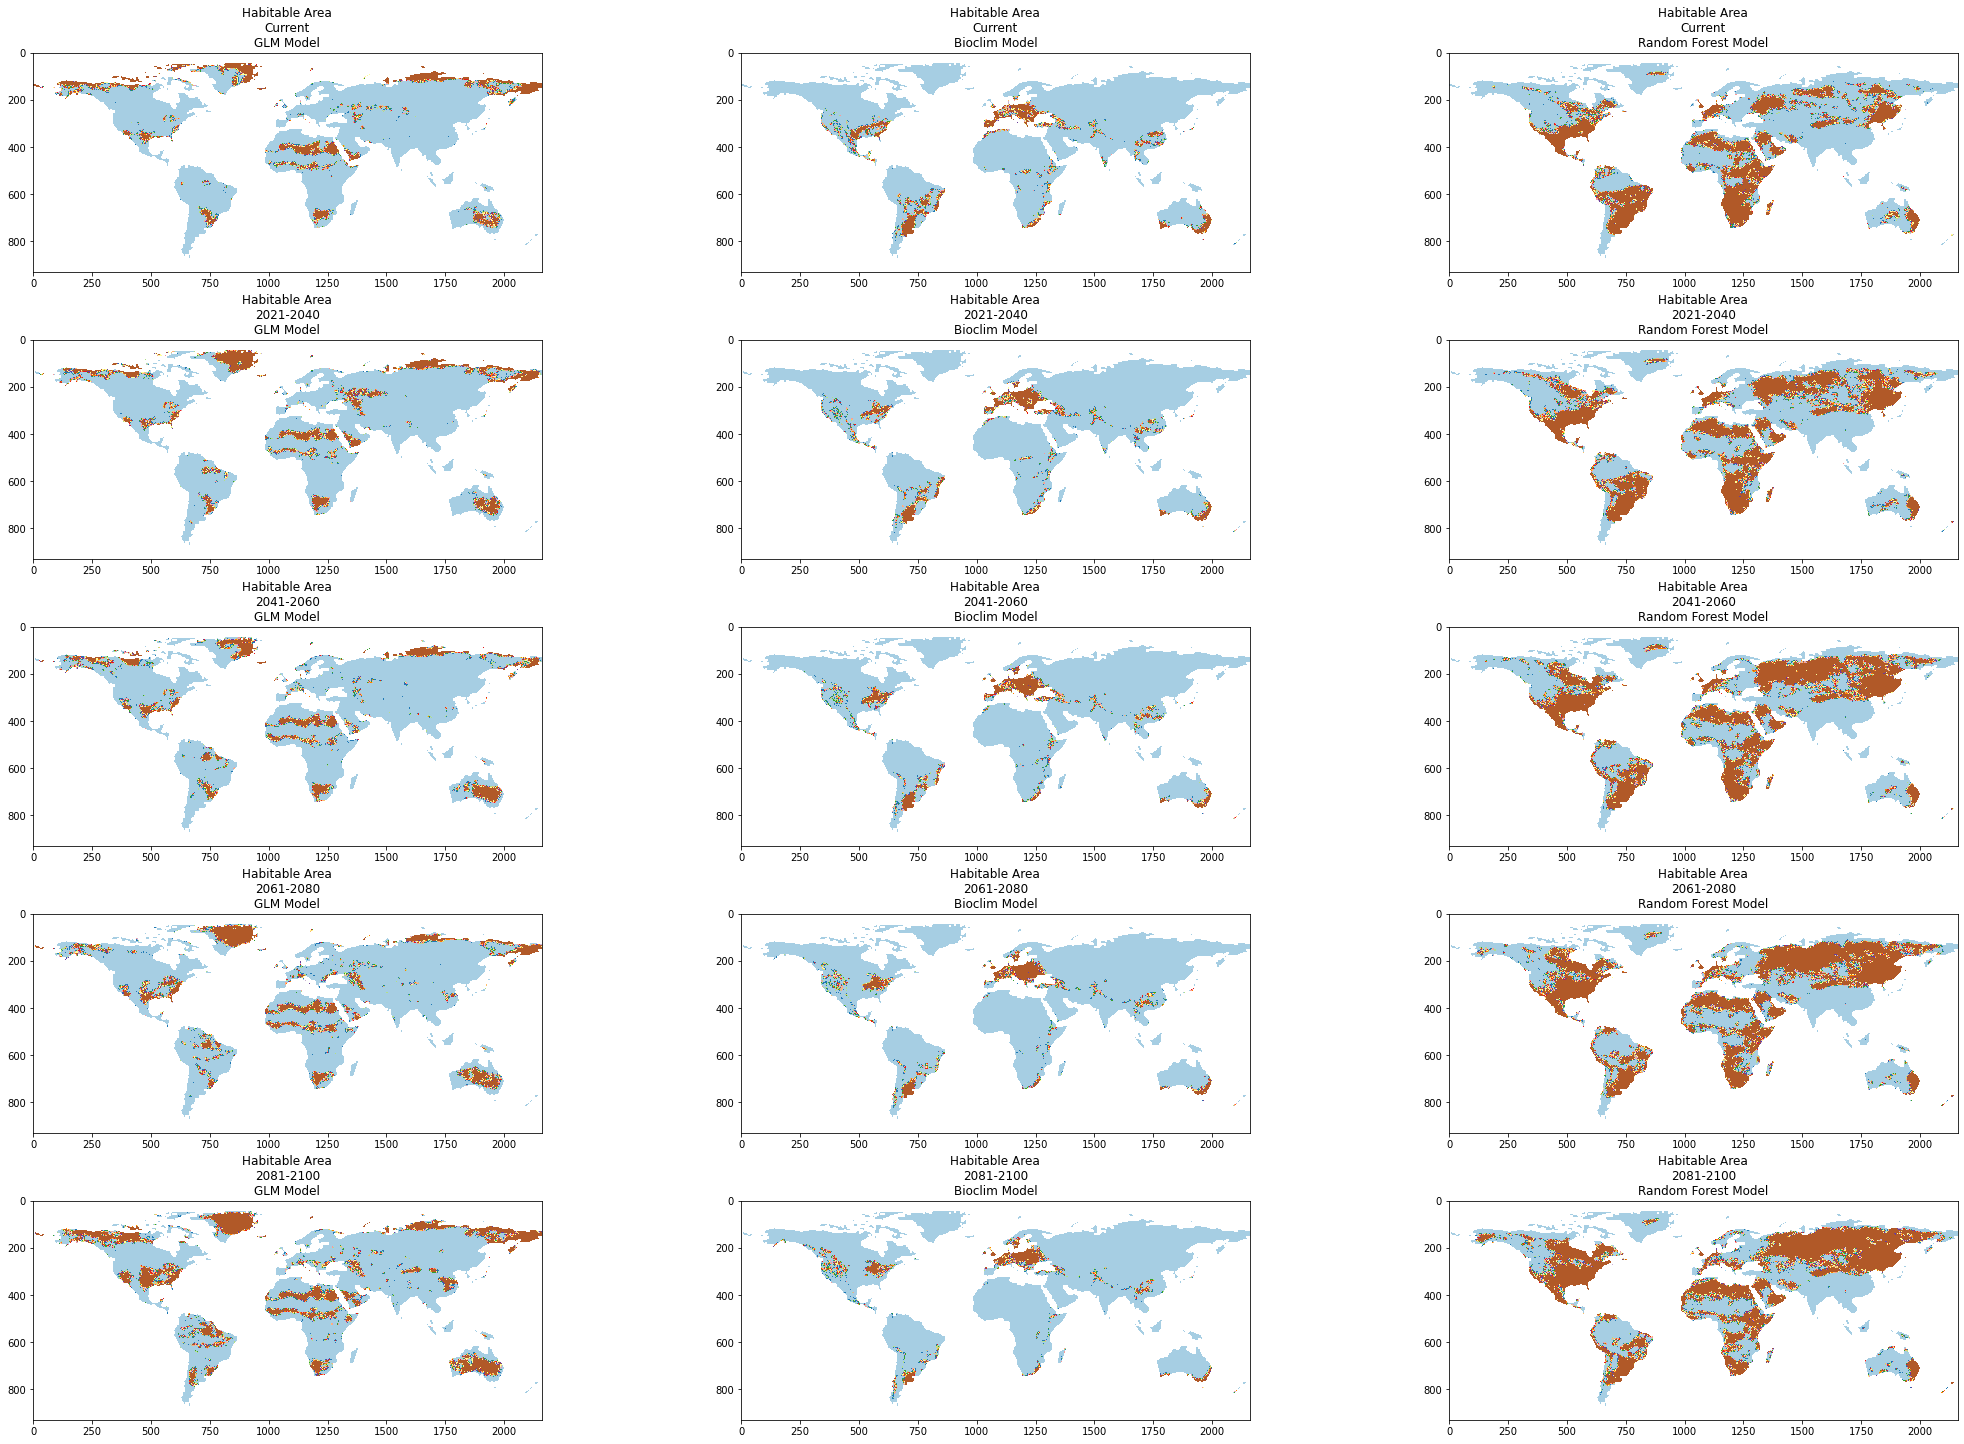

In [ ]:
j = 0
cmap = 'Paired'

model = 'MIROC6'
scenario = 'ssp585'

ID = model + "_" + scenario + "_"

# plot the data for the present
f = plt.figure(figsize=(30, 20))
a = f.add_subplot(5, 3, j+1)
plt.imshow(D['present_glm'], cmap=cmap)
plt.title("""Habitable Area
Current
GLM Model""")
# go to the next plot
j += 1

a = f.add_subplot(5, 3, j+1)
plt.imshow(D['present_bioclim'], cmap=cmap)
plt.title("""Habitable Area
Current
Bioclim Model""")
j += 1

a = f.add_subplot(5, 3, j+1)
plt.imshow(D['present_rf'], cmap=cmap)
plt.title("""Habitable Area
Current
Random Forest Model""")
j += 1

for i, timepoint_future in enumerate(time_periods):
    a = f.add_subplot(5, 3, j+1)
    plt.imshow(D[ID + timepoint_future + '_glm_World'], cmap=cmap)
    plt.title("""Habitable Area
""" + timepoint_future + """
GLM Model""")
    j += 1

    a = f.add_subplot(5, 3, j+1)
    plt.imshow(D[ID + timepoint_future + '_bioclimWorld'],cmap=cmap)
    plt.title("""Habitable Area
""" + timepoint_future + """
Bioclim Model""")
    j += 1

    a = f.add_subplot(5, 3, j+1)
    plt.imshow(D[ID + timepoint_future + '_rfWorld'],cmap=cmap)
    plt.title("""Habitable Area
""" + timepoint_future + """
Random Forest Model""")
    j += 1
plt.tight_layout(pad=0.5)
plt.savefig(file_path + "model_prediction_maps/" + species_name + "_" + ID + ".png")

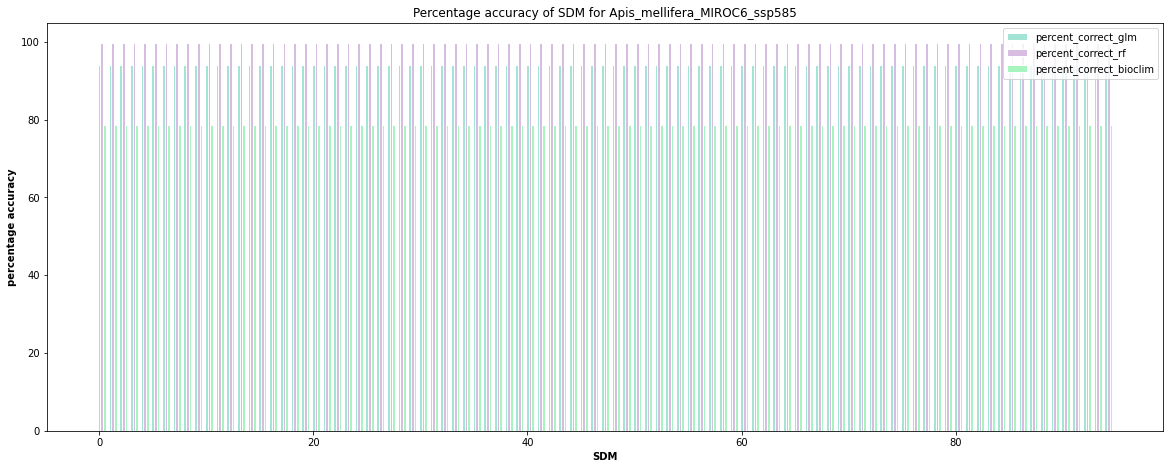

In [ ]:
#barplot comparing the models 
barWidth = 0.25
plt.figure(figsize=(20, 7.5))
a = plt.subplot(111)
bars1 = percent_correct_glm
bars2 = percent_correct_rf
bars3 = percent_correct_bioclim
r1 = np.arange(bars1)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, bars1, color='#a3e4d7', width=barWidth, edgecolor='white', label='percent_correct_glm')
plt.bar(r2, bars2, color='#d7bde2', width=barWidth, edgecolor='white', label='percent_correct_rf')
plt.bar(r3, bars3, color='#a7f4be', width=barWidth, edgecolor='white', label='percent_correct_bioclim')
plt.xlabel('SDM', fontweight='bold')
plt.ylabel('percentage accuracy', fontweight='bold')
plt.title('Percentage accuracy of SDM for ' + species_name + '_' + model + '_' + scenario)
plt.legend()
plt.show()